## Complete pipeline to check if count of 1's in a 10 bit string is greater than count of 0's

In [ ]:
# mostly torch imports and plot imports
import os
import sys
import cv2
# mostly torch imports and plot imports
import torch
import shutil
import glob
import pickle
import random
random.seed(42)
# import colorama
# from colorama import Fore, Style
import numpy as np
np.random.seed(42)
import torch.utils
import torchvision
from torch import optim
import torch.distributions
torch.manual_seed(42)
from tqdm import tqdm
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from matplotlib import rc, rcParams
from numpy import sin

use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))
device = torch.device("cuda" if use_cuda else "cpu")
print("Device to be used : ",device)

use_cuda: True
Device to be used :  cuda


In [ ]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:

class ClassificationNetwork(nn.Module):
    def __init__(self):
        super(ClassificationNetwork, self).__init__()
        self.fc1 = nn.Linear(10, 2)
        self.fc2 = nn.Linear(2,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create an instance of the network
model = ClassificationNetwork()

In [ ]:
class DataGenerator(Dataset):
    def __init__(self, X_VALUES, Y_VALUES, choice):
        self.X = X_VALUES
        self.Y = Y_VALUES
        self.choice = choice

    def __get__number__(self, str_num):
        return np.fromiter((int(bit) for bit in str_num), dtype=np.int8)

    # NUMBER OF FILES IN THE DATASET
    def __len__(self):
        return len(self.X)

    # GETTING SINGLE PAIR OF DATA
    def __getitem__(self, idx):
        # print("X = ",self.X)
        # print("idx = ",idx)
        X_numpy = self.__get__number__(self.X[idx])
        # X_numpy_reshaped = X_numpy.reshape((1, 10))
        # print("X_numpy_reshaped = ", torch.FloatTensor(X_numpy_reshaped))
        # print("Y = ", torch.FloatTensor(self.Y[idx]))
        # return torch.FloatTensor(X_numpy_reshaped), torch.FloatTensor(self.Y[idx])
        return torch.FloatTensor(X_numpy), self.Y[idx] #torch.FloatTensor(self.Y[idx])



In [ ]:
def load_data(X_VALUES, Y_VALUES, choice="train", batch_size=2, num_workers=10, shuffle=True):
    dataset = DataGenerator(X_VALUES, Y_VALUES, choice=choice)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return data_loader


# save checkpoint in pytorch
def save_ckp(checkpoint, checkpoint_path):
    torch.save(checkpoint, checkpoint_path)


# load checkpoint in pytorch
def load_ckp(checkpoint_path, model, model_opt):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model_opt.load_state_dict(checkpoint['optimizer'])
    return model, model_opt, checkpoint['epoch']

In [ ]:
def train_epoch(train_loader, model, optimizer, epoch):
    print("\n\n---------------------------------------------------------------------------------------------------------------\n")

    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0

    N = 0

    for step, (x, y) in progress_bar:
        # if mask_1 is None and low_res_img is None:
        #     continue
        model.train()

        #TRANSFERRING DATA TO DEVICE
        x = x.to(device)
        y = y.to(device)

        # clear the gradient
        optimizer.zero_grad()

        #GETTING THE PREDICTED IMAGE
        # print("x shape == ",x.shape)
        pred_y = model.forward(x)

        # print ("**************")
        # print (pred_y.shape)
        y = y.unsqueeze(-1)
        # print (y.shape)
        # print ("$$$$$$$$$$$$$$$")
        y = y.float()

        #LOSS FUNCTIONS
        BCELOSS = nn.BCELoss()

        #CALCULATING LOSSES
        BCE_loss = BCELOSS(pred_y, y)

        # print (f'Prediction: {pred_y} | {y}')

        #LOSS TAKEN INTO CONSIDERATION
        loss = BCE_loss


        # CALCULATING METRICS
        total_loss += loss

        # print(loss)

        #BACKPROPAGATING THE LOSS
        loss.backward()
        optimizer.step()

        #DISPLAYING THE LOSS
        # progress_bar.set_description("Epoch: {} -  Loss: {} ".format(epoch, loss))

        N += x.shape[0]


    with open("history/train_logs.txt", "a") as text_file:
        text_file.write("{} {}\n".format(epoch, total_loss))

    # print("Training Epoch: {} |  Total Loss: {} | Total Dice: {} | Total Jaccard: {} | N: {}".format(epoch,total_loss, total_dice, total_jacard,N))
    print("Training Epoch: {} |  Loss: {}".format(epoch, total_loss/N))

    return model, optimizer



def test_epoch(test_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0

    #SETTING THE NUMBER OF IMAGES TO CHECK AFTER EACH ITERATION
    no_img_to_write = 20

    total_loss = 0.0

    N = 0
    for step, (x, y) in progress_bar:

        x = x.to(device)
        y = y.to(device)


        #PREDICTED IMAGE
        pred_y = model.forward(x)

        #LOSS FUNCTIONS
        BCELOSS = nn.BCELoss()

        model.eval()

        y = y.unsqueeze(-1)
        y = y.float()

        #CALCULATING LOSSES
        BCE_loss = BCELOSS(pred_y, y)

        #LOSS TAKEN INTO CONSIDERATION
        loss = BCE_loss

        # CALCULATING METRICS
        total_loss += loss

        N += x.shape[0]


        # progress_bar.set_description("Epoch: {} -  Loss: {} ".format(epoch, total_loss))


    with open("history/test_logs.txt", "a") as text_file:
        text_file.write("{} {}\n".format(epoch, total_loss))

    print("Test Epoch: {} |  Loss: {}".format(epoch, total_loss/N))
    print("---------------------------------------------------------------------------------------------------------------")



In [ ]:
def train_val_test(train_loader, test_loader, model, optimizer, n_epoch, resume):

    #PATH TO SAVE THE CHECKPOINT
    checkpoint_path = "checkpoint/classification_net.pt"

    epoch = 0
    #IF TRAINING IS TO RESUMED FROM A CERTAIN CHECKPOINT
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while epoch <= n_epoch:
        epoch += 1
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch)

        #CHECKPOINT CREATION
        checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}

        #CHECKPOINT SAVING
        save_ckp(checkpoint, checkpoint_path)
        print("Checkpoint Saved")

    print("************************ Final Test Epoch *****************************")

    with torch.no_grad():
        test_epoch(test_loader, model, optimizer, epoch)

In [ ]:
def one_gt_zero(bit_string):
    # Count the number of 1's and 0's in the bit string
    count_ones = bit_string.count('1')
    count_zeros = bit_string.count('0')

    # Check if the number of 1's is greater than the number of 0's
    return count_ones > count_zeros

def generate_10_bit_binary_numbers():
    binary_numbers = []

    for i in range(2**10):
        binary_str = format(i, '010b')
        binary_numbers.append(binary_str)

    return binary_numbers


# Generate and store all 10-bit binary numbers
binary_numbers_list = generate_10_bit_binary_numbers()


Y_VALUES = []
X_VALUES = []

# Print and/or use the generated binary numbers as needed
for binary_number in binary_numbers_list:
    #print(binary_number)
    if one_gt_zero(binary_number) == True:
        X_VALUES.append(binary_number)
        Y_VALUES.append(1)
    else:
        X_VALUES.append(binary_number)
        Y_VALUES.append(0)

In [ ]:
for item1, item2 in zip(X_VALUES[500:530], Y_VALUES[500:530]):
    print(item1, item2)

0111110100 1
0111110101 1
0111110110 1
0111110111 1
0111111000 1
0111111001 1
0111111010 1
0111111011 1
0111111100 1
0111111101 1
0111111110 1
0111111111 1
1000000000 0
1000000001 0
1000000010 0
1000000011 0
1000000100 0
1000000101 0
1000000110 0
1000000111 0
1000001000 0
1000001001 0
1000001010 0
1000001011 0
1000001100 0
1000001101 0
1000001110 0
1000001111 0
1000010000 0
1000010001 0


In [ ]:
! mkdir checkpoint

In [ ]:
! mkdir history

In [ ]:
print ('modified!')

train_till = int(0.8*len(X_VALUES))

X_VALUES_TRAIN = X_VALUES[:train_till]
Y_VALUES_TRAIN = Y_VALUES[:train_till]

X_VALUES_TEST = X_VALUES[train_till:]
Y_VALUES_TEST = Y_VALUES[train_till:]

print("Total Number of Training data : ", len(X_VALUES_TRAIN))
print("Total Number of Testing data : ", len(X_VALUES_TEST))


# CREATING THE TRAIN LOADER
train_loader = load_data(
    X_VALUES_TRAIN, Y_VALUES_TRAIN, choice="train", batch_size=16, num_workers=1, shuffle=True)

# #CREATING THE TEST LOADER
test_loader = load_data(
    X_VALUES_TEST, Y_VALUES_TEST, choice="test", batch_size=1, num_workers=1, shuffle=False)

#CALLING THE MODEL
model = ClassificationNetwork()
model = model.to(device)

summary(model, input_size=(1, 10))

#DEFINING THE OPTIMIZER
optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad], lr=5e-03, weight_decay=5e-4)

n_epoch = 200

#INDICATOR VARIABLE TO RESUME TRAINING OR START AFRESH
resume = False
train_val_test(train_loader, test_loader, model, optimizer, n_epoch, resume)





modified!
Total Number of Training data :  819
Total Number of Testing data :  205
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 2]              22
            Linear-2                 [-1, 1, 1]               3
           Sigmoid-3                 [-1, 1, 1]               0
Total params: 25
Trainable params: 25
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------



52it [00:00, 76.40it/s]

Training Epoch: 1 |  Loss: 0.039355289191007614
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 213.49it/s]

Training Epoch: 2 |  Loss: 0.0379328727722168
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 202.96it/s]

Training Epoch: 3 |  Loss: 0.03650357201695442
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 217.81it/s]

Training Epoch: 4 |  Loss: 0.03515559807419777
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 207.99it/s]

Training Epoch: 5 |  Loss: 0.03325916454195976
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 198.02it/s]

Training Epoch: 6 |  Loss: 0.03124481625854969
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 216.66it/s]

Training Epoch: 7 |  Loss: 0.02913094311952591
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 296.83it/s]


Training Epoch: 8 |  Loss: 0.02696193940937519
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 257.73it/s]

Training Epoch: 9 |  Loss: 0.025138845667243004
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 285.73it/s]

Training Epoch: 10 |  Loss: 0.023219935595989227
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 269.41it/s]


Training Epoch: 11 |  Loss: 0.020850947126746178
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 281.12it/s]

Training Epoch: 12 |  Loss: 0.018127022311091423
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 292.63it/s]


Training Epoch: 13 |  Loss: 0.01582915149629116
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 297.29it/s]

Training Epoch: 14 |  Loss: 0.014166953973472118
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 279.29it/s]

Training Epoch: 15 |  Loss: 0.01243008766323328
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 273.53it/s]


Training Epoch: 16 |  Loss: 0.011121012270450592
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 285.93it/s]

Training Epoch: 17 |  Loss: 0.010114969685673714
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 291.94it/s]

Training Epoch: 18 |  Loss: 0.009333182126283646
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 290.62it/s]

Training Epoch: 19 |  Loss: 0.008647440001368523
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 294.33it/s]


Training Epoch: 20 |  Loss: 0.00809144414961338
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 292.85it/s]

Training Epoch: 21 |  Loss: 0.007227086462080479
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 283.67it/s]

Training Epoch: 22 |  Loss: 0.006773714907467365
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 291.07it/s]

Training Epoch: 23 |  Loss: 0.006325514521449804
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 263.64it/s]

Training Epoch: 24 |  Loss: 0.005760961212217808
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 277.71it/s]

Training Epoch: 25 |  Loss: 0.0055960388854146
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 285.18it/s]

Training Epoch: 26 |  Loss: 0.005150383338332176
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 293.52it/s]

Training Epoch: 27 |  Loss: 0.004835806787014008
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 277.64it/s]

Training Epoch: 28 |  Loss: 0.004604035057127476
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 284.56it/s]

Training Epoch: 29 |  Loss: 0.004321044776588678
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 290.17it/s]

Training Epoch: 30 |  Loss: 0.004134687595069408
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 273.92it/s]

Training Epoch: 31 |  Loss: 0.0038659728597849607
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 286.85it/s]

Training Epoch: 32 |  Loss: 0.0036408156156539917
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.50it/s]

Training Epoch: 33 |  Loss: 0.0034854174591600895
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 294.03it/s]

Training Epoch: 34 |  Loss: 0.0033183558844029903
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 301.48it/s]


Training Epoch: 35 |  Loss: 0.003087960183620453
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 238.04it/s]

Training Epoch: 36 |  Loss: 0.0029917354695498943
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 287.24it/s]

Training Epoch: 37 |  Loss: 0.0027759703807532787
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 283.00it/s]

Training Epoch: 38 |  Loss: 0.002603595843538642
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 288.57it/s]

Training Epoch: 39 |  Loss: 0.00256334594450891
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 274.94it/s]

Training Epoch: 40 |  Loss: 0.002366905100643635
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 290.65it/s]

Training Epoch: 41 |  Loss: 0.002349396236240864
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 267.90it/s]


Training Epoch: 42 |  Loss: 0.0021282180678099394
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 292.16it/s]

Training Epoch: 43 |  Loss: 0.0020988991018384695
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 271.57it/s]

Training Epoch: 44 |  Loss: 0.001976330764591694
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 278.16it/s]

Training Epoch: 45 |  Loss: 0.0018965101335197687
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 294.85it/s]

Training Epoch: 46 |  Loss: 0.0017742178170010448
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 266.96it/s]


Training Epoch: 47 |  Loss: 0.001692053396254778
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 261.95it/s]

Training Epoch: 48 |  Loss: 0.0017164848977699876
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 251.99it/s]

Training Epoch: 49 |  Loss: 0.0016105868853628635
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 284.10it/s]

Training Epoch: 50 |  Loss: 0.0015142960473895073
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 296.62it/s]


Training Epoch: 51 |  Loss: 0.0014652517857030034
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 277.29it/s]

Training Epoch: 52 |  Loss: 0.0014203885802999139
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 290.12it/s]


Training Epoch: 53 |  Loss: 0.0013715121895074844
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 291.67it/s]

Training Epoch: 54 |  Loss: 0.0013224708382040262
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 198.25it/s]

Training Epoch: 55 |  Loss: 0.0012527512153610587
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 213.74it/s]

Training Epoch: 56 |  Loss: 0.0012409898918122053
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 214.93it/s]

Training Epoch: 57 |  Loss: 0.0011706388322636485
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 209.28it/s]

Training Epoch: 58 |  Loss: 0.0011571393115445971
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 202.71it/s]

Training Epoch: 59 |  Loss: 0.0011008932488039136
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 204.32it/s]

Training Epoch: 60 |  Loss: 0.0010487905237823725
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 250.88it/s]

Training Epoch: 61 |  Loss: 0.0010141507955268025
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 274.20it/s]

Training Epoch: 62 |  Loss: 0.0009912094101309776
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 292.39it/s]

Training Epoch: 63 |  Loss: 0.0009627279941923916
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 270.04it/s]


Training Epoch: 64 |  Loss: 0.0009538579033687711
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 285.17it/s]

Training Epoch: 65 |  Loss: 0.0009292870527133346
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 280.47it/s]

Training Epoch: 66 |  Loss: 0.00090178003301844
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 270.66it/s]

Training Epoch: 67 |  Loss: 0.0008840466616675258
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 288.54it/s]


Training Epoch: 68 |  Loss: 0.0008715316653251648
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 297.20it/s]


Training Epoch: 69 |  Loss: 0.0008747131796553731
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 282.87it/s]

Training Epoch: 70 |  Loss: 0.0007975377375259995
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 288.39it/s]

Training Epoch: 71 |  Loss: 0.0007908473489806056
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 292.93it/s]

Training Epoch: 72 |  Loss: 0.0007498011109419167
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 290.36it/s]

Training Epoch: 73 |  Loss: 0.0007480860804207623
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 294.61it/s]


Training Epoch: 74 |  Loss: 0.0007579695084132254
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 297.13it/s]

Training Epoch: 75 |  Loss: 0.0007231743657030165
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 284.59it/s]

Training Epoch: 76 |  Loss: 0.0007028529653325677
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 268.86it/s]


Training Epoch: 77 |  Loss: 0.0007047636900097132
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 299.32it/s]


Training Epoch: 78 |  Loss: 0.0006848393240943551
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 285.03it/s]

Training Epoch: 79 |  Loss: 0.000677520118188113
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.91it/s]


Training Epoch: 80 |  Loss: 0.0006652780575677752
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 292.55it/s]

Training Epoch: 81 |  Loss: 0.0006461219163611531
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 278.63it/s]

Training Epoch: 82 |  Loss: 0.0006311891484074295
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 277.05it/s]

Training Epoch: 83 |  Loss: 0.0006293532205745578
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 291.63it/s]

Training Epoch: 84 |  Loss: 0.0006244463147595525
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 287.14it/s]

Training Epoch: 85 |  Loss: 0.0006126817897893488
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.32it/s]

Training Epoch: 86 |  Loss: 0.0006021639565005898
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 285.96it/s]

Training Epoch: 87 |  Loss: 0.0005958700203336775
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 294.81it/s]

Training Epoch: 88 |  Loss: 0.0005861484096385539
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 282.97it/s]

Training Epoch: 89 |  Loss: 0.0005721577908843756
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 276.31it/s]

Training Epoch: 90 |  Loss: 0.0005787760601378977
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 301.93it/s]


Training Epoch: 91 |  Loss: 0.000562946661375463
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 283.93it/s]

Training Epoch: 92 |  Loss: 0.0005572541267611086
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 290.19it/s]

Training Epoch: 93 |  Loss: 0.0005559055134654045
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 293.17it/s]

Training Epoch: 94 |  Loss: 0.0005406737327575684
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 291.25it/s]


Training Epoch: 95 |  Loss: 0.0005464960704557598
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 293.49it/s]

Training Epoch: 96 |  Loss: 0.0005476853111758828
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 284.82it/s]

Training Epoch: 97 |  Loss: 0.0005437888903543353
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 272.69it/s]

Training Epoch: 98 |  Loss: 0.0005369236459955573
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 287.04it/s]

Training Epoch: 99 |  Loss: 0.0005401041707955301
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 287.28it/s]

Training Epoch: 100 |  Loss: 0.0005202108877710998
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 291.69it/s]

Training Epoch: 101 |  Loss: 0.0005318662733770907
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 270.74it/s]


Training Epoch: 102 |  Loss: 0.0005206023924984038
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 291.74it/s]

Training Epoch: 103 |  Loss: 0.0005276903975754976
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 284.09it/s]

Training Epoch: 104 |  Loss: 0.0005161768640391529
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 294.13it/s]

Training Epoch: 105 |  Loss: 0.0004976287600584328
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 293.93it/s]

Training Epoch: 106 |  Loss: 0.0004995345370844007
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 276.07it/s]

Training Epoch: 107 |  Loss: 0.0005012557376176119
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 283.06it/s]

Training Epoch: 108 |  Loss: 0.0005014423513785005
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 239.48it/s]

Training Epoch: 109 |  Loss: 0.0005139160784892738
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 213.84it/s]

Training Epoch: 110 |  Loss: 0.0005062223644927144
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 214.53it/s]

Training Epoch: 111 |  Loss: 0.0004895316669717431
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 227.99it/s]

Training Epoch: 112 |  Loss: 0.0004979861550964415
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 199.15it/s]

Training Epoch: 113 |  Loss: 0.0005058199749328196
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 207.13it/s]

Training Epoch: 114 |  Loss: 0.00048571673687547445
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 212.12it/s]

Training Epoch: 115 |  Loss: 0.000490063801407814
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 293.27it/s]

Training Epoch: 116 |  Loss: 0.0004833104903809726
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 285.05it/s]

Training Epoch: 117 |  Loss: 0.0004768662911374122
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 295.50it/s]


Training Epoch: 118 |  Loss: 0.0004836087755393237
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 285.39it/s]

Training Epoch: 119 |  Loss: 0.00047733879182487726
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 282.89it/s]

Training Epoch: 120 |  Loss: 0.00048207759391516447
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.67it/s]

Training Epoch: 121 |  Loss: 0.0004714752431027591
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 292.53it/s]


Training Epoch: 122 |  Loss: 0.00048627331852912903
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 285.48it/s]

Training Epoch: 123 |  Loss: 0.0004710689827334136
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 281.70it/s]

Training Epoch: 124 |  Loss: 0.0004799317684955895
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 294.55it/s]

Training Epoch: 125 |  Loss: 0.00048108372720889747
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 291.29it/s]

Training Epoch: 126 |  Loss: 0.00046649976866319776
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 300.70it/s]

Training Epoch: 127 |  Loss: 0.00045986828627064824
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.99it/s]


Training Epoch: 128 |  Loss: 0.00045955737004987895
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 270.59it/s]

Training Epoch: 129 |  Loss: 0.0004580426320899278
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 288.38it/s]

Training Epoch: 130 |  Loss: 0.0004917146288789809
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 295.08it/s]

Training Epoch: 131 |  Loss: 0.00047687182086519897
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 284.11it/s]

Training Epoch: 132 |  Loss: 0.00046757858945056796
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.39it/s]

Training Epoch: 133 |  Loss: 0.0004521386290434748
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 278.60it/s]

Training Epoch: 134 |  Loss: 0.0004687045293394476
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 282.17it/s]

Training Epoch: 135 |  Loss: 0.0004528706194832921
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 285.92it/s]

Training Epoch: 136 |  Loss: 0.0004501626535784453
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 281.84it/s]

Training Epoch: 137 |  Loss: 0.00045228496310301125
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.04it/s]


Training Epoch: 138 |  Loss: 0.0004534280451480299
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 273.89it/s]

Training Epoch: 139 |  Loss: 0.0004548201395664364
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 297.59it/s]


Training Epoch: 140 |  Loss: 0.00044466363033279777
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 270.40it/s]


Training Epoch: 141 |  Loss: 0.0004526598786469549
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 283.99it/s]

Training Epoch: 142 |  Loss: 0.00044176646042615175
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 300.76it/s]

Training Epoch: 143 |  Loss: 0.00046723027480766177
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 276.26it/s]

Training Epoch: 144 |  Loss: 0.00045520521234720945
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 297.53it/s]


Training Epoch: 145 |  Loss: 0.0004413560964167118
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 287.94it/s]

Training Epoch: 146 |  Loss: 0.0004410761466715485
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 285.23it/s]

Training Epoch: 147 |  Loss: 0.0004525664262473583
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 268.81it/s]

Training Epoch: 148 |  Loss: 0.0004457592440303415
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 275.15it/s]

Training Epoch: 149 |  Loss: 0.0004350096278358251
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 290.01it/s]

Training Epoch: 150 |  Loss: 0.000431405525887385
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 260.49it/s]

Training Epoch: 151 |  Loss: 0.0004404326609801501
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 275.77it/s]

Training Epoch: 152 |  Loss: 0.0004476597532629967
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 279.57it/s]

Training Epoch: 153 |  Loss: 0.0004441206401679665
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 270.54it/s]


Training Epoch: 154 |  Loss: 0.0004390261019580066
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 271.65it/s]


Training Epoch: 155 |  Loss: 0.000439180206740275
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 289.72it/s]

Training Epoch: 156 |  Loss: 0.00045122308074496686
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 287.44it/s]

Training Epoch: 157 |  Loss: 0.0004426199593581259
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 279.84it/s]

Training Epoch: 158 |  Loss: 0.00043563227518461645
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 276.09it/s]


Training Epoch: 159 |  Loss: 0.0004396597796585411
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 289.17it/s]

Training Epoch: 160 |  Loss: 0.0004191929765511304
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 281.91it/s]

Training Epoch: 161 |  Loss: 0.000435225258115679
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.99it/s]


Training Epoch: 162 |  Loss: 0.00044225924648344517
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 272.14it/s]


Training Epoch: 163 |  Loss: 0.0004462903016246855
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 211.16it/s]

Training Epoch: 164 |  Loss: 0.00042487462633289397
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 206.58it/s]

Training Epoch: 165 |  Loss: 0.00042647679219953716
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 224.74it/s]

Training Epoch: 166 |  Loss: 0.00042278500040993094
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 212.97it/s]

Training Epoch: 167 |  Loss: 0.0004253797815181315
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 202.48it/s]

Training Epoch: 168 |  Loss: 0.00043122106580995023
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 200.58it/s]

Training Epoch: 169 |  Loss: 0.00042306940304115415
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 197.58it/s]

Training Epoch: 170 |  Loss: 0.00043099888716824353
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 280.46it/s]

Training Epoch: 171 |  Loss: 0.0004316396079957485
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 281.56it/s]

Training Epoch: 172 |  Loss: 0.00043070371611975133
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 278.18it/s]

Training Epoch: 173 |  Loss: 0.0004213557986076921
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 275.22it/s]


Training Epoch: 174 |  Loss: 0.0004418343596626073
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 289.54it/s]

Training Epoch: 175 |  Loss: 0.00041601102566346526
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 192.10it/s]

Training Epoch: 176 |  Loss: 0.0004359935410320759
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 283.22it/s]

Training Epoch: 177 |  Loss: 0.00041842047357931733
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 280.83it/s]

Training Epoch: 178 |  Loss: 0.000428306229878217
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 286.99it/s]

Training Epoch: 179 |  Loss: 0.00042894636862911284
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 276.54it/s]

Training Epoch: 180 |  Loss: 0.0004215446824673563
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 252.23it/s]

Training Epoch: 181 |  Loss: 0.0004235738597344607
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 296.93it/s]

Training Epoch: 182 |  Loss: 0.000417037692386657
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 290.32it/s]


Training Epoch: 183 |  Loss: 0.00042795369517989457
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 284.68it/s]

Training Epoch: 184 |  Loss: 0.00042401556856930256
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 275.05it/s]

Training Epoch: 185 |  Loss: 0.00042074653902091086
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 275.14it/s]

Training Epoch: 186 |  Loss: 0.00042022799607366323
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 283.09it/s]

Training Epoch: 187 |  Loss: 0.00041581207187846303
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 282.38it/s]

Training Epoch: 188 |  Loss: 0.00041396485175937414
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.84it/s]

Training Epoch: 189 |  Loss: 0.00040764553705230355
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 276.60it/s]

Training Epoch: 190 |  Loss: 0.0004270156496204436
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 289.09it/s]

Training Epoch: 191 |  Loss: 0.00041917734779417515
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 281.69it/s]

Training Epoch: 192 |  Loss: 0.00042064208537340164
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 274.95it/s]

Training Epoch: 193 |  Loss: 0.00042852756450884044
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 281.69it/s]

Training Epoch: 194 |  Loss: 0.0004276690597180277
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 290.32it/s]

Training Epoch: 195 |  Loss: 0.00041482795495539904
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 283.32it/s]

Training Epoch: 196 |  Loss: 0.00041462923400104046
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 280.86it/s]

Training Epoch: 197 |  Loss: 0.0004061490762978792
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 279.65it/s]

Training Epoch: 198 |  Loss: 0.00041336589492857456
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 279.41it/s]

Training Epoch: 199 |  Loss: 0.00043839268619194627
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------




52it [00:00, 293.93it/s]


Training Epoch: 200 |  Loss: 0.00042522489093244076
Checkpoint Saved


---------------------------------------------------------------------------------------------------------------



52it [00:00, 288.76it/s]

Training Epoch: 201 |  Loss: 0.00040747676393948495
Checkpoint Saved
************************ Final Test Epoch *****************************



205it [00:00, 474.43it/s]

Test Epoch: 201 |  Loss: 0.007740654982626438
---------------------------------------------------------------------------------------------------------------


### Calculating Precision

In [ ]:
def precision(result, reference):
    result = np.atleast_1d(result.astype(np.bool_))
    reference = np.atleast_1d(reference.astype(np.bool_))

    tp = np.count_nonzero(result & reference)
    fp = np.count_nonzero(result & ~reference)

    try:
        precision = tp / float(tp + fp)
    except ZeroDivisionError:
        precision = 0.0

    return precision

In [ ]:
# Calculating Precision
ALL_PREDS_VALUES = []
ALL_Y_VALUES = []

progress_bar = tqdm(enumerate(test_loader))
total_loss = 0.0

N = 0
for step, (x, y) in progress_bar:
    x = x.to(device)
    y = y.to(device)


    #PREDICTED IMAGE
    pred_y = model.forward(x)

    #LOSS FUNCTIONS
    BCELOSS = nn.BCELoss()

    model.eval()

    y = y.unsqueeze(-1)
    y = y.float()
    threshold = 0.5
    if pred_y.item() > threshold:
        ALL_PREDS_VALUES.append(1)
    else:
        ALL_PREDS_VALUES.append(0)
    ALL_Y_VALUES.append(int(y.item()))

ALL_Y_VALUES = np.array(ALL_Y_VALUES)
ALL_PREDS_VALUES = np.array(ALL_PREDS_VALUES)

205it [00:00, 509.68it/s]


In [ ]:
ALL_Y_VALUES

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [ ]:
ALL_PREDS_VALUES

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [ ]:
precision_val = precision(ALL_PREDS_VALUES, ALL_Y_VALUES)
print("precision ==> ",precision_val)

precision ==>  1.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args:
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='rocket_r')
    #plt.savefig(filename)
    plt.savefig('confusion_matrix.png')
    plt.savefig('confusion_matrix.eps')
    #plt.show()


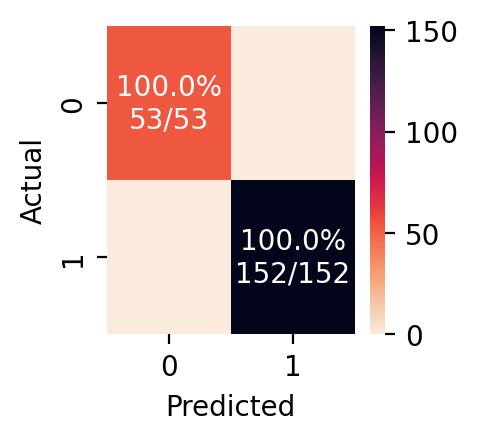

In [ ]:
cm_analysis(ALL_Y_VALUES, ALL_PREDS_VALUES, [0, 1] , ymap=None,figsize=(2,2))

### Checking hidden layer weights

In [ ]:
model

ClassificationNetwork(
  (fc1): Linear(in_features=10, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
model.fc1.weight.shape

torch.Size([2, 10])

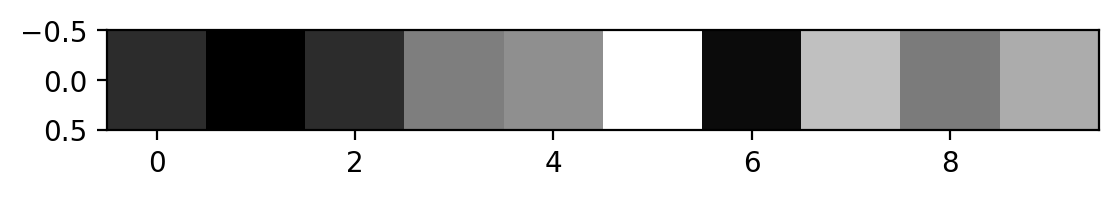

In [ ]:
plt.imshow(model.fc1.weight[0].cpu().detach().numpy().reshape(1,10),cmap='gray')
plt.show()

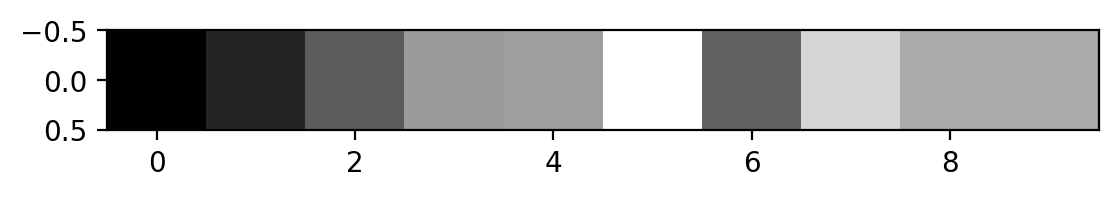

In [ ]:
plt.imshow(model.fc1.weight[1].cpu().detach().numpy().reshape(1,10),cmap='gray')
plt.show()

In [ ]:
model.fc2.weight

Parameter containing:
tensor([[-5.3614,  5.0216]], device='cuda:0', requires_grad=True)

#### Exercise: Check assignments for possible exercises, you will be using this code base as a skeleton for making necessary changes.